## **UNETR - Architecture**

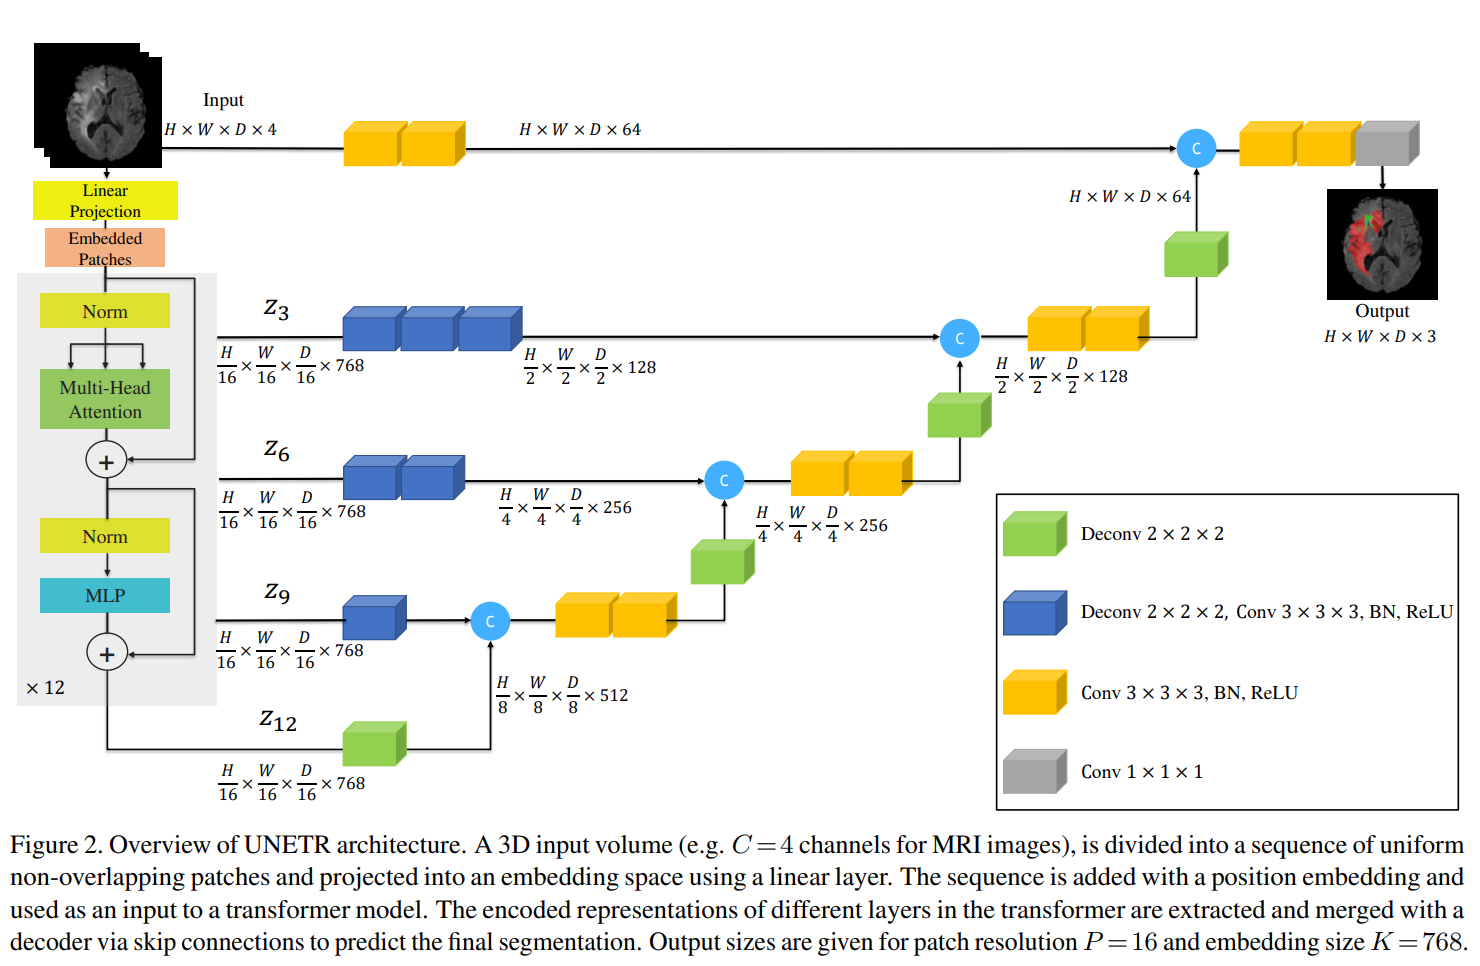

In [1]:
!pip install monai==0.6

In [2]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [3]:
'''
in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int, tuple or str, optional) – Padding added to all six sides of the input. Default: 0

padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True
'''
class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)

In [4]:
class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)

In [5]:
'''
The yellow box in the architecture
Cnv3d 3x3x3 + Batch Normalisation + ReLU
'''


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [6]:
'''
The blue box in the architecture
Deconv 2x2x2 + Conv 3x3x3 + Batch Normalisation + ReLU
'''

class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

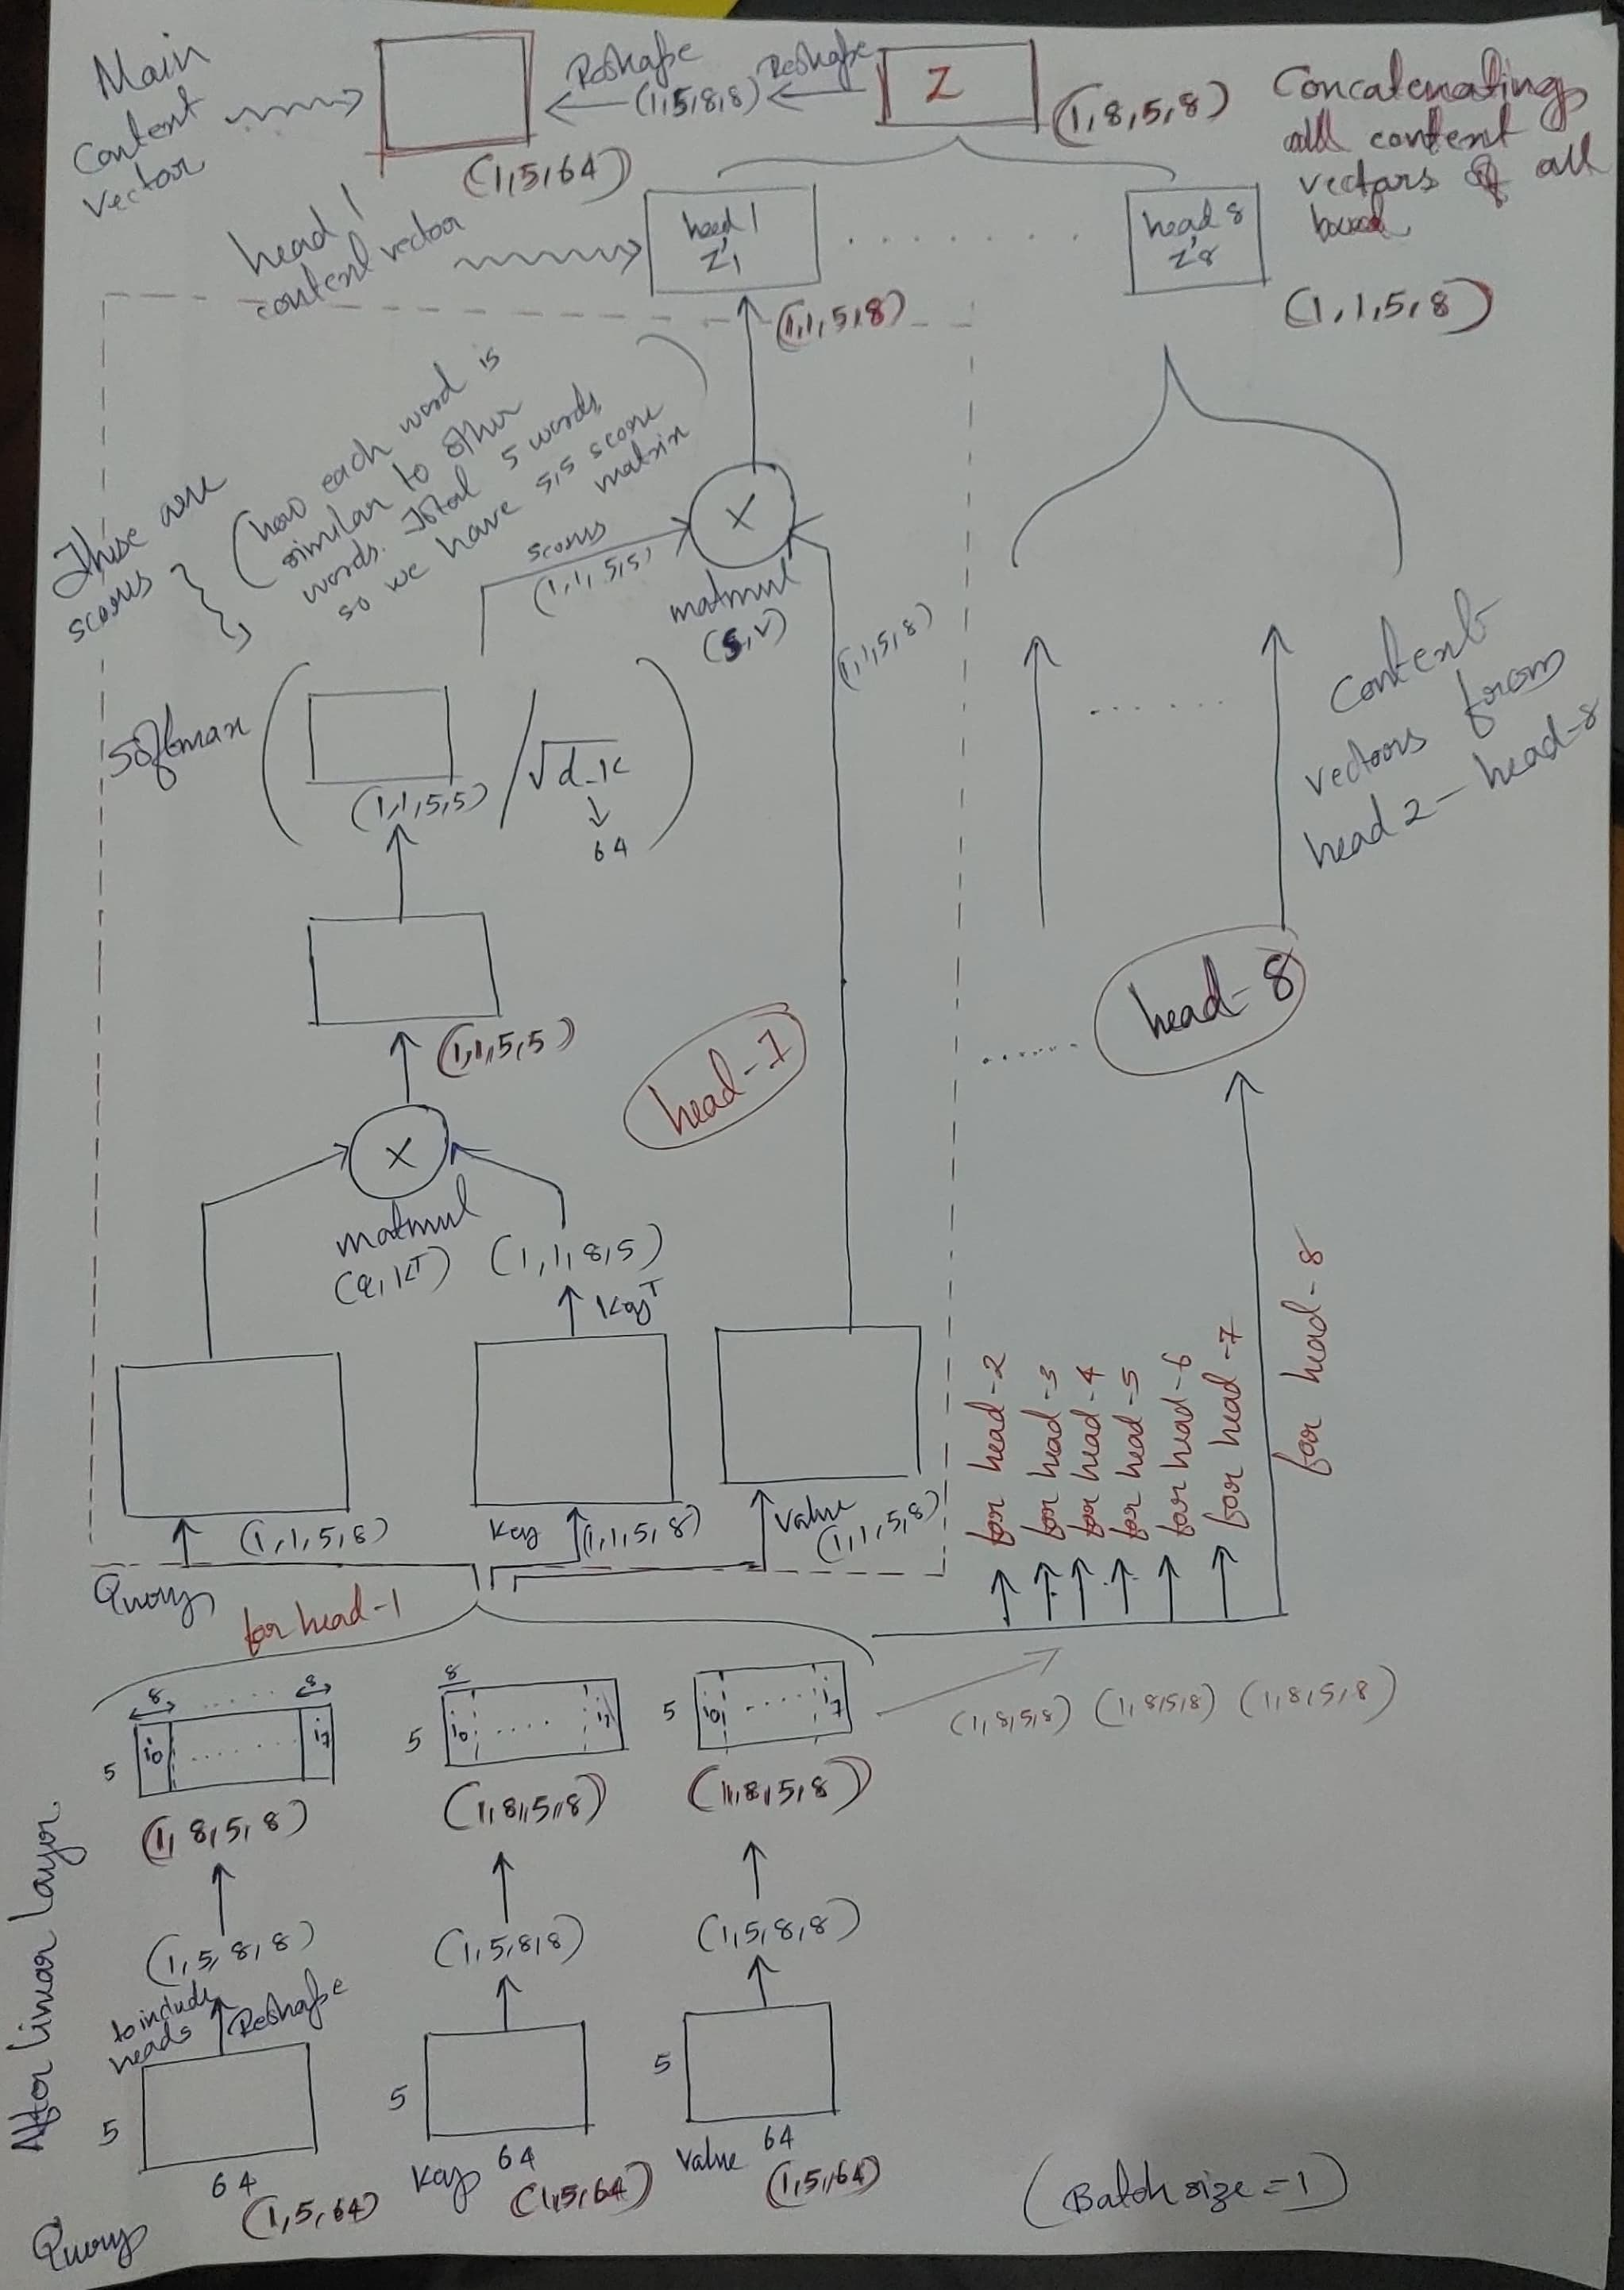

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # self.all_head_size = self.all_head_size + (embed_dim - self.all_head_size)
        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):

        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)

        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


In [8]:
class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x

In [9]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


In [10]:
class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # They used convolution operation for making patches. Where kernel size is the patch_size, anstride is patch_size.
        # In normal ViT, there is a flattening layer followed by a Dense layer"
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # print("size of x before is : ",x.shape)
        # print("size of  pos_emb before is :",self.position_embeddings.shape)
        x = self.patch_embeddings(x)
        x = x.flatten(2) # the output of conv layer(a matrix) is then flattened.
        x = x.transpose(-1, -2)
        # x = x.reshape(1, 512, 512)
        # print("size of x is : ",x.shape)
        # print("size of pos_emb is :",self.position_embeddings.shape)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights

In [12]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers  # this will contains the input of every layer (num of layers if encoder)

In [13]:
#   Conv3DBlock = Yellow
#   Deconv3DBlock = Blue
#   SingleDeconv3DBlock = Green
#   SingleConv3DBlock = Gray

In [14]:
class UNETR_from_scratch(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

## **BRATS Dataset**

BRATS is a multi-modal large-scale 3D imaging dataset. It contains 4 3D volumes of MRI images captured under different modalities and setups. Here is a sample of the dataset. It is important to see that only the tumor is annotated. This makes things such as segmentation more difficult since the model has to localize on the tumor.

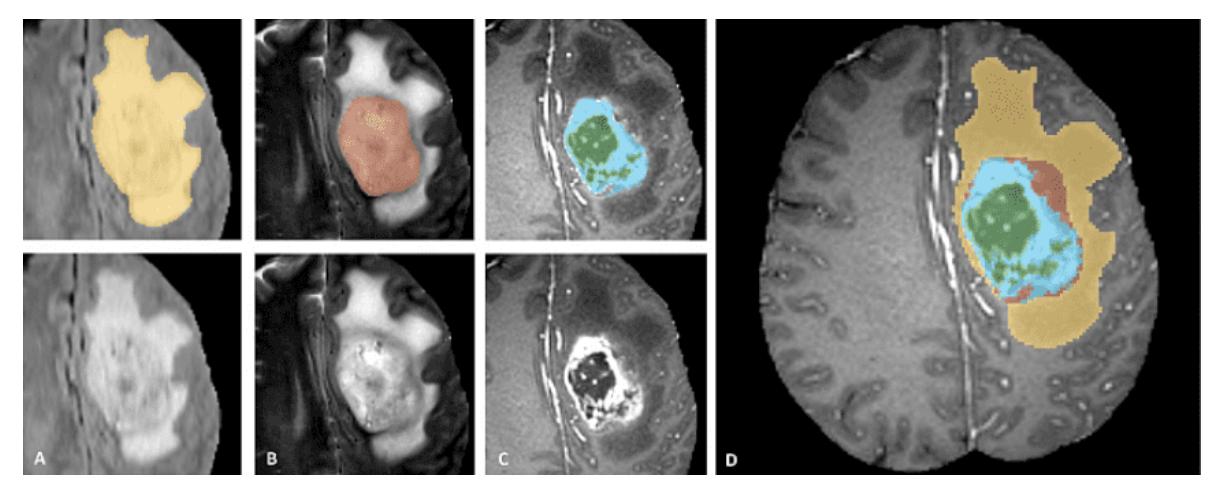

The image patches depict tumor categories as follows (from left to right):

**Edema**: The whole tumor (yellow) is usually visible in T2-FLAIR MRI image.

**Non-enhancing solid core**: The tumor core (red) visible in T2 MRI.

The enhancing tumor structures (light blue). Usually visible in T1Gd, surrounding the necrotic core (green).

The segmentations are combined to generate the final labels of the dataset.

With MONAI, loading a dataset from the medical imaging decathlon competition becomes trivial.



**Data loading with MONAI and transformations**

By utilizing the DecathlonDataset class of MONAI library one can load any of the 10 available datasets from the website. We will use Task01_BrainTumour in our case.

In [15]:
from monai.transforms import (
   Activations,
   AsChannelFirstd,
   AsDiscrete,
   CenterSpatialCropd,
   Compose,
   LoadImaged,
   MapTransform,
   NormalizeIntensityd,
   Orientationd,
   RandFlipd,
   RandScaleIntensityd,
   RandShiftIntensityd,
   RandSpatialCropd,
   Spacingd,
   ToTensord,
)
roi_size=[64, 64, 64]
pixdim=(1.5, 1.5, 2.0)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
   """
   Convert labels to multi channels based on brats classes:
   label 1 is the peritumoral edema
   label 2 is the GD-enhancing tumor
   label 3 is the necrotic and non-enhancing tumor core
   The possible classes are TC (Tumor core), WT (Whole tumor)
   and ET (Enhancing tumor).

   """

   def __call__(self, data):
       d = dict(data)
       for key in self.keys:
           result = []
           # merge label 2 and label 3 to construct TC
           result.append(np.logical_or(d[key] == 2, d[key] == 3))
           # merge labels 1, 2 and 3 to construct WT
           result.append(
               np.logical_or(
                   np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
               )
           )
           # label 2 is ET
           result.append(d[key] == 2)
           d[key] = np.stack(result, axis=0).astype(np.float32)
       return d

train_transform = Compose(
   [
       # load 4 Nifti images and stack them together
       LoadImaged(keys=["image", "label"]),
       AsChannelFirstd(keys="image"),
       ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
       Spacingd(
           keys=["image", "label"],
           pixdim=pixdim,
           mode=("bilinear", "nearest"),
       ),
       Orientationd(keys=["image", "label"], axcodes="RAS"),
       RandSpatialCropd(
           keys=["image", "label"], roi_size=roi_size, random_size=False),
       RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
       NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
       RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
       RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
       ToTensord(keys=["image", "label"]),
   ]
)
val_transform = Compose(
   [
       LoadImaged(keys=["image", "label"]),
       AsChannelFirstd(keys="image"),
       ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
       Spacingd(
           keys=["image", "label"],
           pixdim=pixdim,
           mode=("bilinear", "nearest"),
       ),
       Orientationd(keys=["image", "label"], axcodes="RAS"),
       CenterSpatialCropd(keys=["image", "label"], roi_size=roi_size),
       NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
       ToTensord(keys=["image", "label"]),
   ]
)

Imports and supporting functions can be found in the notebook. What’s crucial here is the transformation pipeline, which I guarantee is not an easy thing in 3D images. MONAI provides some functions to make a fast pipeline for the purpose of this tutorial. Details like the image orientation are left out of the tutorial on purpose.

Briefly, we will resample our images to a voxel size of 1.5, 1.5, and 2.0 mm in each dimension. Afterwards, we take random 3D sub-volumes of sizes 128, 128, 64. This of course needs to be applied to both the input image and the segmentation mask.

Then a couple of augmentations are applied such as randomly flipping the first axis, and rescaling the intensity (jittering).

The class ConvertToMultiChannelBasedOnBratsClassesd brings the labels to the format that we want.

In [16]:
cache_num = 8
from monai.apps import DecathlonDataset
from torch.utils.data import DataLoader

train_ds = DecathlonDataset(
   root_dir="./",
   task="Task01_BrainTumour",
   transform=train_transform,
   section="training",
   download=True,
   num_workers=4,
   cache_num=cache_num,
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_ds = DecathlonDataset(
   root_dir="./",
   task="Task01_BrainTumour",
   transform=val_transform,
   section="validation",
   download=False,
   num_workers=4,
   cache_num=cache_num,
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
File exists: ./Task01_BrainTumour.tar, skipped downloading.
Non-empty folder exists in ./Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


## **Training**

In [17]:
# device = torch.device("cuda:0")
# num_heads = 12
# embed_dim= 512

# model = UNETR_from_scratch(embed_dim=512,num_heads = 12).to(device)

Another readily available library for UNETR.
If the UNETR from scratch is giving error , use this.

In [18]:
!pip install self-attention-cv==1.2.3

In [19]:
from self_attention_cv import UNETR
device = torch.device("cuda:0")
num_heads = 10
embed_dim= 512

model = UNETR(img_shape=tuple(roi_size), input_dim=4, output_dim=3,
                embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
                ext_layers=[3, 6, 9, 12], norm='instance',
                base_filters=16,
                dim_linear_block=2048).to(device)

In [ ]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

max_epochs = 1
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []

for epoch in range(max_epochs):
   print(f"epoch {epoch + 1}/{max_epochs}")
   model.train()
   epoch_loss = 0
   step = 0
   for batch_data in train_loader:
       step += 1
       inputs, labels = (
           batch_data["image"].to(device),
           batch_data["label"].to(device),
       )
       optimizer.zero_grad()
       outputs = model(inputs)


       loss = loss_function(outputs, labels)
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()

   epoch_loss /= step
   epoch_loss_values.append(epoch_loss)
   print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")